In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import PointsStrokesTransformer
from lib.strokes import VectorsStrokesTransformer
from lib.strokes import PolarStrokesTransformer
from lib.strokes import get_n_points, cut_strokes
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.plot import get_canvas, plot, get_animation
from lib.model import Decoder
from lib.model import evaluate, train

# Load and show dataset

In [4]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = unpack_drawings('./data/cat.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

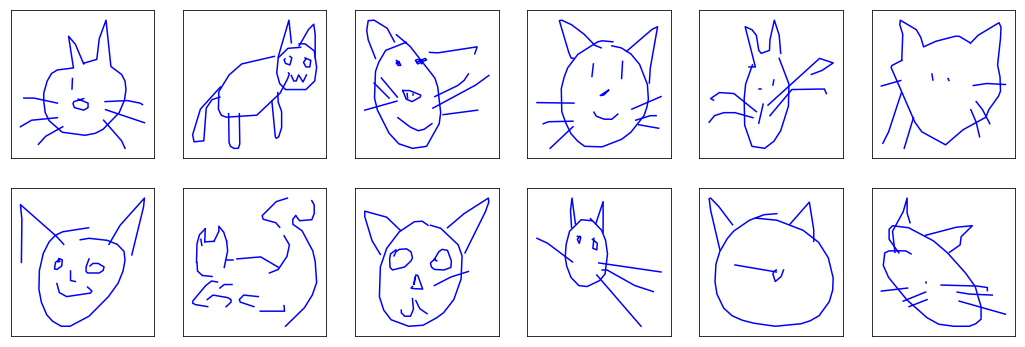

In [6]:
fig, axarr = get_canvas(2, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

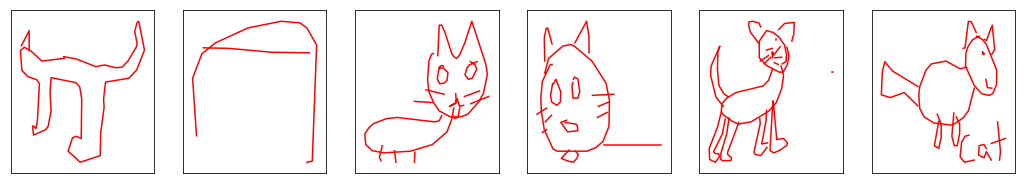

In [7]:
fig, axarr = get_canvas(1, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

# Transform drawings

to an internal representation suitable for modeling

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'y')

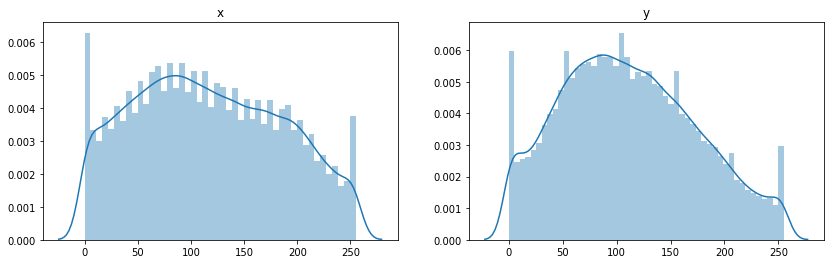

In [10]:
transform = PointsStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

xs, ys = [], []
for transformed_drawing in transformed_drawings:
    xs += list(map(operator.itemgetter(0), transformed_drawing))
    ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(xs, ax=axs[0]).set_title('x')
sns.distplot(ys, ax=axs[1]).set_title('y')

Stroke points do not follow a gaussian distribution.

Text(0.5,1,'delta_y')

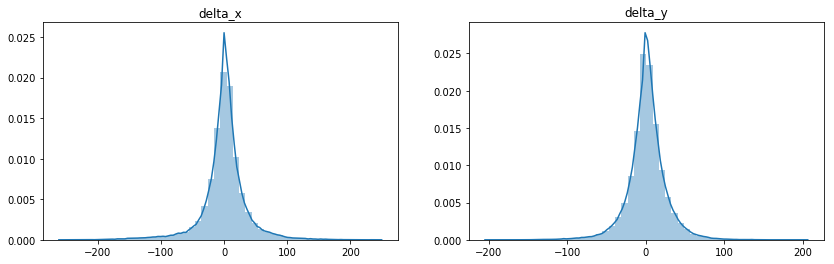

In [11]:
transform = VectorsStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

Stroke vectors follow a gaussian distribution.

Text(0.5,1,'alpha')

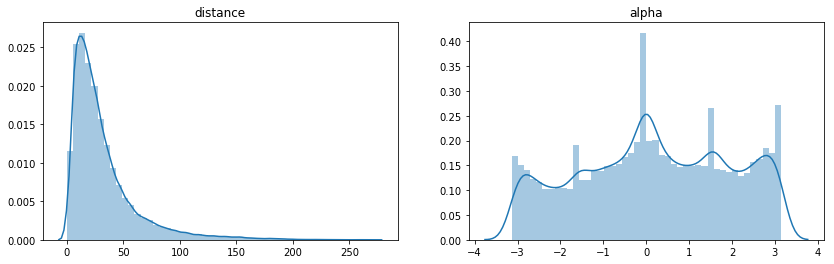

In [12]:
transform = PolarStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

distances, alphas = [], []
for transformed_drawing in transformed_drawings:
    distances += list(map(operator.itemgetter(0), transformed_drawing))
    alphas += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(distances, ax=axs[0]).set_title('distance')
sns.distplot(alphas, ax=axs[1]).set_title('alpha')

Stroke polar-coordinates vectors do not follow a gaussian distribution.

# Create pytorch dataset

In [13]:
transformer = VectorsStrokesTransformer()
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transformer.transform(drawing) for drawing in drawings]

In [14]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [15]:
ds = get_dataset(transformed_drawings)

In [16]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.15)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(11644, 3862)

In [17]:
standarize = True
sigmas = 1

if standarize:
    train_means_stds = get_means_stds(train_ds, sigmas)
    val_means_stds = get_means_stds(val_ds, sigmas)
else:
    train_means_stds = ([0, 1], [0, 1])
    val_means_stds = ([0, 1], [0, 1])

In [18]:
# Debug
train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lens_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lens_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lens_batch):
    print(tensor)
    print()

torch.Size([173, 2, 5]) torch.Size([173, 2, 5]) torch.Size([2])


tensor([[[ 0.0105, -1.5006,  1.0000,  0.0000,  0.0000],
         [ 0.0000, -2.2095,  1.0000,  0.0000,  0.0000]],

        [[ 0.1199, -0.6342,  1.0000,  0.0000,  0.0000],
         [ 0.1199, -1.1068,  1.0000,  0.0000,  0.0000]],

        [[ 0.4481,  0.3898,  1.0000,  0.0000,  0.0000],
         [ 0.6123,  1.3350,  1.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0')

tensor([[[ 0.1199, -0.6342,  1.0000,  0.0000,  0.0000],
         [ 0.1199, -1.1068,  1.0000,  0.0000,  0.0000]],

        [[ 0.4481,  0.3898,  1.0000,  0.0000,  0.0000],
         [ 0.6123,  1.3350,  1.0000,  0.0000,  0

In [19]:
K = 4
model = Decoder(n_hidden=5, K=K)

if torch.cuda.is_available():
    model = model.cuda()

train_batches = get_batches(train_ds, train_means_stds, batch_size=1024)
data_batch, labels_batch, lens_batch = next(iter(train_batches))

gmm_params, state_params, (hidden_state, cell_state) = model(data_batch, lens_batch)
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params

In [20]:
print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)
print(state_params.shape)
print(hidden_state.shape, cell_state.shape)

torch.Size([145, 1024, 4])
torch.Size([145, 1024, 4]) torch.Size([145, 1024, 4])
torch.Size([145, 1024, 4]) torch.Size([145, 1024, 4]) torch.Size([145, 1024, 4])
torch.Size([145, 1024, 3])
torch.Size([1, 1024, 5]) torch.Size([1, 1024, 5])


In [21]:
def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho_xy):
    
    z_x = ((x - mu_x) / sigma_x) ** 2
    z_y = ((y - mu_y) / sigma_y) ** 2
    z_xy = (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y)
    z = z_x + z_y - 2 * rho_xy * z_xy
    exp = torch.exp(-z / (2 * (1 - rho_xy ** 2)))
    norm = 2 * np.pi * sigma_x * sigma_y * torch.sqrt(1 - rho_xy ** 2)
    
    return exp / norm

In [22]:
max_len = lens_batch.max()
points = labels_batch[:max_len, :, :2]
points_x, points_y = points.split(1, dim=-1)
points_x = points_x.repeat(1, 1, K)
points_y = points_y.repeat(1, 1, K)

In [23]:
bivariate_normal_pdf(points_x, points_y, *gmm_params[1:]).shape

torch.Size([145, 1024, 4])

In [24]:
from torch.distributions.multivariate_normal import MultivariateNormal

def reconstruction_loss(gmm_params, state_params, labels_batch, lens_batch):

    pi = gmm_params[0]
    K = pi.shape[2]
    
    max_len = lens_batch.max()
    batch_size = labels_batch.shape[1]
    mask = torch.zeros(max_len, batch_size)
    for i, length in enumerate(lens_batch):
        mask[:length, i] = 1

    points = labels_batch[:max_len, :, :2]
    points_x, points_y = points.split(1, dim=-1)
    points_x = points_x.repeat(1, 1, K)
    points_y = points_y.repeat(1, 1, K)
    gaussian_probs = bivariate_normal_pdf(points_x, points_y, *gmm_params[1:])

    gmm_probas = (gaussian_probs * pi).sum(dim=-1) + 1e-5
    points_loss = -gmm_probas[mask == 1].log().mean()

    stroke_states = labels_batch[:max_len, :, 2:]
    states_losses = (stroke_states * state_params.log()).sum(dim=-1)
    states_loss = -states_losses[mask == 1].mean()

    return points_loss + states_loss

In [25]:
reconstruction_loss(gmm_params, state_params, labels_batch, lens_batch)

tensor(3.5314, device='cuda:0', grad_fn=<ThAddBackward>)

In [26]:
def bivariate_normal_distribution(mu_x, mu_y, sigma_x, sigma_y, rho_xy):

    mu_x = mu_x.unsqueeze(-1)
    mu_y = mu_y.unsqueeze(-1)
    sigma_x = sigma_x.unsqueeze(-1)
    sigma_y = sigma_y.unsqueeze(-1)
    rho_xy = rho_xy.unsqueeze(-1)

    mu = torch.cat([mu_x, mu_y], dim=-1)

    sigma_xy = sigma_x * sigma_y
    upper_row_cov = torch.cat([sigma_x ** 2, rho_xy * sigma_xy], dim=-1).unsqueeze(-2)
    lower_row_cov = torch.cat([rho_xy * sigma_xy, sigma_y ** 2], dim=-1).unsqueeze(-2)
    cov = torch.cat([upper_row_cov, lower_row_cov], dim=-2)

    return MultivariateNormal(mu, cov)

In [27]:
last_gmm_params = [param[-1] for param in gmm_params][1:]
bivariate_normal_distribution(*last_gmm_params).sample().shape

torch.Size([1024, 4, 2])

In [28]:
from torch.distributions.multinomial import Multinomial

def sample(gmm_params, state_params):

    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
    
    gaussians = bivariate_normal_distribution(mu_x, mu_y, sigma_x, sigma_y, rho_xy)
    pi = pi.unsqueeze(dim=-1).repeat(1, 1, 2)
    gmm_preds = (pi * gaussians.sample()).sum(dim=-2)

    state_preds = Multinomial(1, state_params[-1]).sample()

    preds = torch.cat([gmm_preds, state_preds], dim=1)
    
    return preds

In [29]:
last_gmm_params = [param[-1] for param in gmm_params]
sample(last_gmm_params, state_params)

tensor([[-0.1860,  0.0120,  1.0000,  0.0000,  0.0000],
        [-0.1765, -0.4289,  0.0000,  1.0000,  0.0000],
        [ 0.8202, -0.5582,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.0254, -0.5362,  1.0000,  0.0000,  0.0000],
        [-0.2655, -0.3564,  0.0000,  1.0000,  0.0000],
        [ 0.0521, -0.5580,  0.0000,  0.0000,  1.0000]],
       device='cuda:0', grad_fn=<CatBackward>)

In [30]:
start_of_stroke = data_batch[:2, :1, :]
start_of_stroke.shape

n_points = 3

In [31]:
def generate(model, start_of_stroke, n_points):

    last_preds = start_of_stroke

    preds = [last_preds]
    states = None
    for _ in range(n_points):
        with torch.no_grad():
            gmm_params, state_params, states = model(last_preds, [len(last_preds)], states)
            last_gmm_params = [param[-1] for param in gmm_params]
        last_preds = sample(last_gmm_params, state_params)
        last_preds = last_preds.unsqueeze(0)
        preds.append(last_preds)

    preds = torch.cat(preds).squeeze(1)
    
    return preds

In [32]:
generate(model, start_of_stroke, n_points)

tensor([[ 0.0105, -1.5006,  1.0000,  0.0000,  0.0000],
        [ 0.1199, -0.6342,  1.0000,  0.0000,  0.0000],
        [ 0.5265,  0.0515,  1.0000,  0.0000,  0.0000],
        [ 0.0018, -0.4543,  0.0000,  1.0000,  0.0000],
        [-0.0206, -0.6392,  1.0000,  0.0000,  0.0000]], device='cuda:0')

# Train

In [33]:
batch_size = 512
n_hidden = 128

model = Decoder(n_hidden, K=6)
if torch.cuda.is_available():
    model = model.cuda()

criterion = reconstruction_loss
optimizer = Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [36]:
print(model)

Decoder(
  (lstm): LSTM(5, 128)
  (output_weights): Linear(in_features=128, out_features=39, bias=True)
)


In [37]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 3.11595   val_loss: 3.12162
epoch:  10   train_loss: 2.23162   val_loss: 2.23409
epoch:  20   train_loss: 1.88295   val_loss: 1.88700
epoch:  30   train_loss: 1.70388   val_loss: 1.71148
epoch:  40   train_loss: 1.58218   val_loss: 1.59408
epoch:  50   train_loss: 1.49907   val_loss: 1.51473
epoch:  60   train_loss: 1.43440   val_loss: 1.45417
epoch:  70   train_loss: 1.38542   val_loss: 1.40822
epoch:  80   train_loss: 1.34652   val_loss: 1.37271
epoch:  90   train_loss: 1.31461   val_loss: 1.34441
epoch: 100   train_loss: 1.28777   val_loss: 1.32103


In [38]:
torch.save(model.state_dict(), 'cat1.pth')

In [39]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.28528   val_loss: 1.31888
epoch:  10   train_loss: 1.26405   val_loss: 1.30071
epoch:  20   train_loss: 1.24260   val_loss: 1.28274
epoch:  30   train_loss: 1.22335   val_loss: 1.26712
epoch:  40   train_loss: 1.20630   val_loss: 1.25375
epoch:  50   train_loss: 1.19107   val_loss: 1.24236
epoch:  60   train_loss: 1.17765   val_loss: 1.23291
epoch:  70   train_loss: 1.16600   val_loss: 1.22539
epoch:  80   train_loss: 1.15436   val_loss: 1.21740
epoch:  90   train_loss: 1.14281   val_loss: 1.20973
epoch: 100   train_loss: 1.13096   val_loss: 1.20128


In [40]:
torch.save(model.state_dict(), 'cat2.pth')

In [41]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.13005   val_loss: 1.20079
epoch:  10   train_loss: 1.12052   val_loss: 1.19430
epoch:  20   train_loss: 1.11144   val_loss: 1.18858
epoch:  30   train_loss: 1.10304   val_loss: 1.18344
epoch:  40   train_loss: 1.09545   val_loss: 1.17913
epoch:  50   train_loss: 1.08863   val_loss: 1.17566
epoch:  60   train_loss: 1.08273   val_loss: 1.17251
epoch:  70   train_loss: 1.07534   val_loss: 1.16819
epoch:  80   train_loss: 1.07082   val_loss: 1.16674
epoch:  90   train_loss: 1.06753   val_loss: 1.16651
epoch: 100   train_loss: 1.05984   val_loss: 1.16244


In [42]:
torch.save(model.state_dict(), 'cat3.pth')

In [97]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.05941   val_loss: 1.16231
epoch:  10   train_loss: 1.05600   val_loss: 1.16145
epoch:  20   train_loss: 1.05034   val_loss: 1.15736
epoch:  30   train_loss: 1.04291   val_loss: 1.15366
epoch:  40   train_loss: 1.03638   val_loss: 1.14987
epoch:  50   train_loss: 1.03121   val_loss: 1.14718
epoch:  60   train_loss: 1.02664   val_loss: 1.14578
epoch:  70   train_loss: 1.02221   val_loss: 1.14410
epoch:  80   train_loss: 1.01785   val_loss: 1.14227
epoch:  90   train_loss: 1.01403   val_loss: 1.14115
epoch: 100   train_loss: 1.01295   val_loss: 1.14058


In [98]:
torch.save(model.state_dict(), 'cat4.pth')

In [99]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.00910   val_loss: 1.13809
epoch:  10   train_loss: 1.01388   val_loss: 1.14392
Epoch   411: reducing learning rate of group 0 to 1.0000e-04.
epoch:  20   train_loss: 0.98588   val_loss: 1.12349
Epoch   425: reducing learning rate of group 0 to 1.0000e-05.
epoch:  30   train_loss: 0.98375   val_loss: 1.12267
Epoch   437: reducing learning rate of group 0 to 1.0000e-06.
epoch:  40   train_loss: 0.98364   val_loss: 1.12289
Epoch   448: reducing learning rate of group 0 to 1.0000e-07.
epoch:  50   train_loss: 0.98362   val_loss: 1.12294
Epoch   459: reducing learning rate of group 0 to 1.0000e-08.
epoch:  60   train_loss: 0.98362   val_loss: 1.12295
epoch:  70   train_loss: 0.98362   val_loss: 1.12295
epoch:  80   train_loss: 0.98362   val_loss: 1.12295
epoch:  90   train_loss: 0.98362   val_loss: 1.12295
epoch: 100   train_loss: 0.98362   val_loss: 1.12295


In [100]:
torch.save(model.state_dict(), 'cat5.pth')

# Predict

In [107]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load('cat5.pth', map_location=map_location))

In [108]:
n_initial_points = 2

idx = np.random.choice(len(val_ds))
flat_strokes = val_ds[idx][0].tolist()
start_of_stroke = flat_strokes[:n_initial_points]
start_of_stroke = torch.Tensor(start_of_stroke).unsqueeze(dim=1)
standarize_data(start_of_stroke, get_means_stds(val_ds))

if torch.cuda.is_available():
    start_of_stroke = start_of_stroke.cuda()

In [109]:
pred_flat_strokes = generate(model, start_of_stroke, 50)
pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
#pred_flat_strokes

In [110]:
%%capture

from lib.plot import get_animation

strokes = transformer.inverse_transform(flat_strokes)
anim = get_animation(strokes)

cut_drawing = cut_strokes(strokes, n_initial_points)
cut_anim = get_animation(cut_drawing)

pred_strokes = transformer.inverse_transform(pred_flat_strokes)
pred_anim = get_animation(pred_strokes)

In [111]:
# Ground truth drawing
HTML(anim.to_html5_video())

In [112]:
# Ground truth drawing
HTML(cut_anim.to_html5_video())

In [113]:
# Generated drawing
HTML(pred_anim.to_html5_video())

In [114]:
pred_anim.save('cat.gif', dpi=80, writer='imagemagick')